In [1]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [2]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [4]:
# зададим API ключ
ek.set_app_key('ccebd1ff788d4574818be93e35c4741925ac214e')

In [5]:
rics_german_df = pd.read_excel('C:/DAN/t_systems/trade_project/rics_german_excel.xlsx')
sort_cols = ['DAX', 'German_telecom', 'Company Market Cap']
rics_german_df = rics_german_df.sort_values(by=sort_cols, ascending=False) # .reset_index(drop=True)
rics_german_df.index = range(0, len(rics_german_df))
rics_german_df

,ric,Company Common Name,Country of Exchange,Primary Country of Risk,TRBC Industry Group Name,TRBC Industry Name,Price Close,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,Germany,Germany,Telecommunications Services,Integrated Telecommunications Services,18.032030,8.580246e+10,1,1
1,SAPG.DE,SAP SE,Germany,Germany,Software & IT Services,Software,122.335901,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,Germany,Germany,Consumer Goods Conglomerates,Consumer Goods Conglomerates,139.347250,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,Germany,Germany,Insurance,Multiline Insurance & Brokers,235.534278,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,Germany,Germany,Automobiles & Auto Parts,Auto & Truck Manufacturers,182.653284,9.619011e+10,1,0
...,...,...,...,...,...,...,...,...,...,...
1486,IXM0392.DE,MSCI Pac ex Jap ETF,Germany,NaN,NaN,NaN,164.045417,NaN,0,0
1487,IXM0402.DE,MSCI Canada ETF,Germany,NaN,NaN,NaN,147.258410,NaN,0,0
1488,IXM0422.DE,MSCI USA ETF,Germany,NaN,NaN,NaN,368.704250,NaN,0,0
1489,IXM0432.DE,MSCI Jap ETF,Germany,NaN,NaN,NaN,179.058138,NaN,0,0


In [6]:
condition_german = rics_german_df['Country of Exchange'] == 'Germany'
condition_telecom = rics_german_df['TRBC Industry Group Name'] == 'Telecommunications Services'
rics_german_telekom_df = rics_german_df[condition_german & condition_telecom]
rics_german_telekom_df[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,8.580246e+10,1,1
27,O2Dn.DE,Telefonica Deutschland Holding AG,8.088962e+09,0,1
28,UTDI.DE,United Internet AG,7.962405e+09,0,1
29,DRIG.DE,1&1 Drillisch AG,4.331541e+09,0,1
30,FNTGn.DE,freenet AG,2.614030e+09,0,1
31,TC1n.DE,Tele Columbus AG,3.688837e+08,0,1
32,NFN.DE,NFON AG,3.245050e+08,0,1
33,E4CG.DE,Ecotel Communication AG,3.558930e+07,0,1
34,PH6.F,Philion SE,2.065664e+05,0,1


In [46]:
condition_dax = (rics_german_df['DAX'] == 1) & (rics_german_df['German_telecom'] != 1)
rics_dax = rics_german_df[condition_dax]
rics_dax[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
1,SAPG.DE,SAP SE,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,9.619011e+10,1,0
5,DAIGn.DE,Daimler AG,7.532200e+10,1,0
6,BASFn.DE,BASF SE,7.222737e+10,1,0
7,ADSGn.DE,Adidas AG,7.062461e+10,1,0
8,DPWGn.DE,Deutsche Post AG,5.932596e+10,1,0
9,BMWG.DE,Bayerische Motoren Werke AG,5.780708e+10,1,0
10,BAYGn.DE,Bayer AG,5.621811e+10,1,0


In [8]:
def get_name_of_latest_file_in_folder(folder_name):
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    most_latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return most_latest_file_dir

In [9]:
# Создадим df, в который будем сохранять вообще все новости.

# Можем создать пустой df, куда будем добавлять все новости
# all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

# Но если мы уже сохраняли файл, достанем самый свежий из папки
most_latest_file = get_name_of_latest_file_in_folder('C:/DAN/t_systems/trade_project/backup_headlines/')
all_headlines_df = pd.read_csv(most_latest_file, sep='~')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, most_latest_file)

(14018, 6) C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-29_v11.csv


In [10]:
# Создадим подобие logger'а 

# quasi_logger = pd.DataFrame(data = [], columns=[
#     'ric_i', 'ric_now', 'headlines_slice_i', 'headlines_number',
#     'up_to_date_ric', 'story_i', 'story_id_now', 'story_is_success', 
#     'date_time',
# ])

# Так как у нас уже есть созданный logger, подгрузим его
most_latest_file = get_name_of_latest_file_in_folder('C:/DAN/t_systems/trade_project/logger/')
quasi_logger = pd.read_csv(most_latest_file, sep=';')
print(quasi_logger.shape, most_latest_file)

(10844, 9) C:/DAN/t_systems/trade_project/logger/quasi_logger_2020-12-29_v10.csv


In [13]:
# Зададим, по какому df мы будет итерировать ric компании (её код на бирже).
rics_to_loop_df = rics_dax
rics_to_loop_df = rics_to_loop_df.reset_index(drop=True) # чтобы юзать .loc()

# Зададим переменную, котролирующую количество выгружаемых за раз заголовков
headlines_count_to_request = 100

# Необходимо задать переменную до цикла как 100, далее она будет изменяться
headlines_number = 100

# Первый цикл будет итерировать компании.
for ric_i in range(0, len(rics_to_loop_df)): # range(0, len(rics_to_loop_df))
    
    # Зададим переменную, которая скажет, какой сейчас итерируется ric.
    ric_now = rics_to_loop_df.loc[ric_i, "ric"]
    print(ric_i, ric_now)
    
    # Цикл, который прогоняет запросы заголовков.
    # Зададим для него параметр. Прибавим +1, если исчерпали новости.
    last_headlines_request = False
    # Будем вести счёт итерацию цикла While для выгрузки заголовков
    headlines_slice_i = 0
    # Для выкачивания заголовков нужно задать дату, до которой делаем запрос.
    # Если такого ric нет в all_headlines_df со всеми новостями,
    # то не будет задавать дату, до которой выкачивать заголовки.
    # Если такой ric есть в all_headlines_df со всеми новостями,
    # то возьмём минимальную дату из all_headlines_df со всеми новостями
    while not last_headlines_request:
        # Проверим, содержит ли all_headlines_df наш текущий ric
        is_this_ric_in_all = ric_now in list(all_headlines_df['ric'])
        print()
        print('is_this_ric_in_all:', is_this_ric_in_all, end=' ')
        if is_this_ric_in_all:
            # Если в нашем датасете присутствует этот ric,
            # то продолжаем по нему выгружать, берём мин имеющуюся дату.
            up_to_date_ric = str(all_headlines_df[all_headlines_df['ric'] == ric_now]['versionCreated'].min())
            print('  up_to_date_ric:', up_to_date_ric, end=' ')
        else:
            # None означает, что метод возьмёт текущий момент времени.
            up_to_date_ric = None
            print('  up_to_date_ric:', up_to_date_ric, end=' ')
        
        news_get_df = ek.get_news_headlines(
            query=ric_now,
            count=headlines_count_to_request,
            date_to=up_to_date_ric
        )
        print('news_get_df.shape:', news_get_df.shape[0])
        
        # Подготовим news_get_df для добавления текст новостей story
        # Для этого добавим столбцы ric, story, тзменим название для headline.
        news_get_df = news_get_df.reset_index(drop=True) # чтобы юзать .loc()
        news_get_df['ric'] = ric_now
        news_get_df['story'] = np.nan
        news_get_df['headline'] = news_get_df['text']
        news_get_df = news_get_df.drop(columns=['text'])
        
        # Добавим тексты новостей к news_get_df по storyId
        for story_i in range(0, len(news_get_df)): # range(0, len(news_get_df))
            story_id_now = news_get_df.loc[story_i, 'storyId']
            
            try:
                story_now = ek.get_news_story(story_id_now)
                # Удалим из истории все тильды на всякий случай.
                story_now = story_now.replace("~","!tilda!")
                # Внесём выкаченную историю в df
                news_get_df.loc[story_i, 'story'] = story_now
                # Пометим, что мы успешно выкачали текст новости
                story_is_success = True
                print(story_i, end='; ')
            
            except: # Exception e
                story_is_success = False
                # Заменим NA на текст ошибки
                news_get_df.loc[story_i, 'story'] = 'error_when_trying_to_collect_story'
                # Выведем story с ошибкой
                print() # e.message
                print(
                    'STORY IS OK:', story_is_success, 
                    '  ric_now:', ric_now,
                    '  ric_i:', ric_i,
                    '  story_i:', story_i
                    )
                time.sleep(5)
            
            finally:
                # В любом случае внесём в наш квази-логгер наблюдение story.
                quasi_logger = quasi_logger.append({
                    "ric_i": ric_i,
                    "ric_now": ric_now,
                    "headlines_slice_i": headlines_slice_i,
                    "headlines_number": headlines_number,
                    "up_to_date_ric": up_to_date_ric,
                    "story_i": story_i,
                    "story_id_now": story_id_now,
                    "story_is_success": story_is_success,
                    "date_time": str(datetime.today())
                }, ignore_index = True)
        
        # Если загруженных заголовков меньше 100, то мы исчерпали новости
        # и нужно переключиться на ric следующей компании.
        headlines_number = news_get_df.shape[0]
        if headlines_number < 100:
            last_headlines_request = True
        
        headlines_slice_i = headlines_slice_i + 1
        
        # На данный момент news_get_df состоит из заголовков и текстов к ним.
        # Добавим их к большому df со всеми статьями.
        all_headlines_df = all_headlines_df.append(news_get_df, ignore_index = True)
        print()
        print(str(datetime.today()), ric_now, 
              ' ric_i:', ric_i,
              ' headline_slice_i:', headlines_slice_i,
              ' headline_number:', headlines_number,
              ' not null:', news_get_df['story'].notna().sum(),
              up_to_date_ric)
    
    # Сохраним версию логгера
    # Подберём такое название, которого нет в dir, чтобы не переписывать файл.
    file_version = 1
    folder_name = 'C:/DAN/t_systems/trade_project/logger/'
    date_now = datetime.today().strftime("%Y-%m-%d")
    file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    while file_name in os.listdir(folder_name):
        file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
        file_version = file_version + 1
    file_path = folder_name + file_name
    quasi_logger.to_csv(file_path, sep = ';', index=False)
    print(file_path)
    
    # Сохраним версию all_headlines_df со всеми новостями
    # Подберём такое название, которого нет в dir, чтобы не переписывать файл.
    file_version = 1
    folder_name = 'C:/DAN/t_systems/trade_project/backup_headlines/'
    date_now = datetime.today().strftime("%Y-%m-%d")
    file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    while file_name in os.listdir(folder_name):
        file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
        file_version = file_version + 1
    # C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
    file_path = folder_name + file_name
    all_headlines_df.to_csv(file_path, sep = '~', index=False)
    print(file_path)

0 SAPG.DE

is_this_ric_in_all: True   up_to_date_ric: 2019-09-30 05:19:23+00:00 news_get_df.shape: 1
0; 
2020-12-30 00:29:05.388419 SAPG.DE  ric_i: 0  headline_slice_i: 1  headline_number: 1  not null: 1 2019-09-30 05:19:23+00:00
C:/DAN/t_systems/trade_project/logger/quasi_logger_2020-12-30_v1.csv
C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-30_v1.csv
1 SIEGn.DE

is_this_ric_in_all: True   up_to_date_ric: 2020-06-24 09:12:52.866000+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 
STORY IS OK: False   ric_now: SIEGn.DE   ric_i: 1   story_i: 61
62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 
STORY IS OK: False   ric_now: SIEGn.DE   ric_i: 1   story_i: 93
94; 95; 96; 97; 98;

2020-12-30 03:23:47,106 P[18872] [MainThread 7824] Error code 503 | Server Error: <html>
<head>
<title>Service unavailable</title>
<style type="text/css">
body {
  background-color: #242424;
  color: #c8c7c7;
  font-family: Calibri, Helvetica, Arial, sans-serif;
  font-size: 16px;
}
</style>
</head>
<!-- Request
Referer: (null)
User-Agent: axios/0.19.2
-->
<!-- Beresponse
Date: Wed, 30 Dec 2020 00:23:46 GMT
HTTP Code: 503
HTTP Beresponse: Backend fetch failed
X-Varnish: 150083685
Backend: AppServerCLD
-->
<body>
 <h1>Service unavailable</h1>
 <p>Service is not available right now, please retry later.</p>
</body>
</html>
2020-12-30 03:23:47,107 P[18872] [MainThread 7824] HTTP request failed: EikonError-Server Error: <html>
<head>
<title>Service unavailable</title>
<style type="text/css">
body {
  background-color: #242424;
  color: #c8c7c7;
  font-family: Calibri, Helvetica, Arial, sans-serif;
  font-size: 16px;
}
</style>
</head>
<!-- Request
Referer: (null)
User-Agent: axios/0.19.2
--


STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 51
52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 03:25:41.870653 ALVG.DE  ric_i: 2  headline_slice_i: 4  headline_number: 100  not null: 99 2020-11-16 18:52:04.172000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-11-06 11:52:06.726000+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 03:30:08.242010 ALVG.DE  ric_i: 2  headline_slice_i: 5  headline_number: 100  not null: 100 2020-11-06 11:

2020-12-30 03:32:26,876 P[18872] [MainThread 7824] UDF Core request failed. Gateway Time-out
2020-12-30 03:32:26,877 P[18872] [MainThread 7824] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 46
47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 03:34:18.154524 ALVG.DE  ric_i: 2  headline_slice_i: 6  headline_number: 100  not null: 98 2020-11-03 09:30:00+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-10-26 09:53:52+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 03:38:27.145626 ALVG.DE  ric_i: 2  headline_slice_i: 7  headline_number: 100  not null: 100 2020-10-

2020-12-30 04:13:08,353 P[18872] [MainThread 7824] UDF Core request failed. Service Temporarily Unavailable
2020-12-30 04:13:08,354 P[18872] [MainThread 7824] HTTP request failed: EikonError-UDF Core request failed. Service Temporarily Unavailable



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 61
62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:14:30.078621 ALVG.DE  ric_i: 2  headline_slice_i: 17  headline_number: 100  not null: 98 2020-05-29 07:40:58+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-05-14 13:15:43+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:18:43.588197 ALVG.DE  ric_i: 2  headline_slice_i: 18  headline_number: 100  not null: 100 2020-05-14 13:15:43+00:00

is_this_ric_in_all: True   up_to_date_r

2020-12-30 04:22:30,048 P[18872] [MainThread 7824] UDF Core request failed. Service Temporarily Unavailable
2020-12-30 04:22:30,049 P[18872] [MainThread 7824] HTTP request failed: EikonError-UDF Core request failed. Service Temporarily Unavailable



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 6
7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 
STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 49
50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:26:21.229100 ALVG.DE  ric_i: 2  headline_slice_i: 20  headline_number: 100  not null: 98 2020-05-04 10:02:16.589000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-27 18:45:48+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 

2020-12-30 04:27:14,052 P[18872] [MainThread 7824] Error code 518 | Server Error: Server Side Timeout - Do Not Resubmit
2020-12-30 04:27:14,053 P[18872] [MainThread 7824] HTTP request failed: EikonError-Server Error: Server Side Timeout - Do Not Resubmit



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 8
9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:30:39.899169 ALVG.DE  ric_i: 2  headline_slice_i: 21  headline_number: 100  not null: 99 2020-04-27 18:45:48+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-09 20:07:01.971000+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88

2020-12-30 04:36:40,037 P[18872] [MainThread 7824] Backend error. 404 Not Found
2020-12-30 04:36:40,037 P[18872] [MainThread 7824] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 77
78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:37:25.076580 ALVG.DE  ric_i: 2  headline_slice_i: 23  headline_number: 100  not null: 99 2020-04-03 07:13:14+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-03-24 10:04:23+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 
STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 89
90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:40:48.338487 ALVG.DE  ric_i: 2  headline_slice_i: 24  headline_number: 100  not null: 99 2020-03-24 10:04:23+00:00

is_this_ric_in_all: True   up_to_date_ric: 2

2020-12-30 04:52:13,023 P[18872] [MainThread 7824] UDF Core request failed. Service Temporarily Unavailable
2020-12-30 04:52:13,024 P[18872] [MainThread 7824] HTTP request failed: EikonError-UDF Core request failed. Service Temporarily Unavailable



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 22
23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 04:55:03.708451 ALVG.DE  ric_i: 2  headline_slice_i: 28  headline_number: 100  not null: 98 2020-02-04 06:54:16+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-01-17 07:47:35.212000+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12

2020-12-30 05:06:07,425 P[18872] [MainThread 7824] Backend error. 404 Not Found
2020-12-30 05:06:07,426 P[18872] [MainThread 7824] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: ALVG.DE   ric_i: 2   story_i: 99

2020-12-30 05:06:12.446997 ALVG.DE  ric_i: 2  headline_slice_i: 31  headline_number: 100  not null: 99 2019-12-07 00:11:45.762000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-11-15 20:02:44.107000+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2020-12-30 05:09:59.399549 ALVG.DE  ric_i: 2  headline_slice_i: 32  headline_number: 100  not null: 100 2019-11-15 20:02:44.107000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-11-08 08:03:09+00:00 news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 

2020-12-30 06:19:14,768 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63646 seconds.
2020-12-30 06:19:14,769 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63646 seconds.


15; 
STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 16


2020-12-30 06:19:19,792 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63641 seconds.
2020-12-30 06:19:19,792 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63641 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 17


2020-12-30 06:19:24,807 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63636 seconds.
2020-12-30 06:19:24,808 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63636 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 18


2020-12-30 06:19:29,829 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63631 seconds.
2020-12-30 06:19:29,830 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63631 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 19


2020-12-30 06:19:34,848 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63626 seconds.
2020-12-30 06:19:34,849 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63626 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 20


2020-12-30 06:19:39,871 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63621 seconds.
2020-12-30 06:19:39,872 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63621 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 21


2020-12-30 06:19:44,897 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63616 seconds.
2020-12-30 06:19:44,898 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63616 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 22


2020-12-30 06:19:49,915 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63611 seconds.
2020-12-30 06:19:49,916 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63611 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 23


2020-12-30 06:19:54,930 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63606 seconds.
2020-12-30 06:19:54,931 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63606 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 24


2020-12-30 06:19:59,948 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63601 seconds.
2020-12-30 06:19:59,948 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63601 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 25


2020-12-30 06:20:04,966 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63596 seconds.
2020-12-30 06:20:04,967 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63596 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 26


2020-12-30 06:20:09,988 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63591 seconds.
2020-12-30 06:20:09,989 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63591 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 27


2020-12-30 06:20:15,010 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63585 seconds.
2020-12-30 06:20:15,010 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63585 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 28


2020-12-30 06:20:20,028 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63580 seconds.
2020-12-30 06:20:20,028 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63580 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 29


2020-12-30 06:20:25,055 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63575 seconds.
2020-12-30 06:20:25,056 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63575 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 30


2020-12-30 06:20:30,083 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63570 seconds.
2020-12-30 06:20:30,083 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63570 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 31


2020-12-30 06:20:35,105 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63565 seconds.
2020-12-30 06:20:35,106 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63565 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 32


2020-12-30 06:20:40,120 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63560 seconds.
2020-12-30 06:20:40,120 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63560 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 33


2020-12-30 06:20:45,133 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63555 seconds.
2020-12-30 06:20:45,134 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63555 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 34


2020-12-30 06:20:50,159 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63550 seconds.
2020-12-30 06:20:50,160 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63550 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 35


2020-12-30 06:20:55,181 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63545 seconds.
2020-12-30 06:20:55,182 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63545 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 36


2020-12-30 06:21:00,197 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63540 seconds.
2020-12-30 06:21:00,198 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63540 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 37


2020-12-30 06:21:05,219 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63535 seconds.
2020-12-30 06:21:05,220 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63535 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 38


2020-12-30 06:21:10,251 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63530 seconds.
2020-12-30 06:21:10,252 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63530 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 39


2020-12-30 06:21:15,272 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63525 seconds.
2020-12-30 06:21:15,273 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63525 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 40


2020-12-30 06:21:20,294 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63520 seconds.
2020-12-30 06:21:20,294 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63520 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 41


2020-12-30 06:21:25,333 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63515 seconds.
2020-12-30 06:21:25,333 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63515 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 42


2020-12-30 06:21:30,347 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63510 seconds.
2020-12-30 06:21:30,347 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63510 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 43


2020-12-30 06:21:35,373 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63505 seconds.
2020-12-30 06:21:35,374 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63505 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 44


2020-12-30 06:21:40,405 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63500 seconds.
2020-12-30 06:21:40,406 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63500 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 45


2020-12-30 06:21:45,430 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63495 seconds.
2020-12-30 06:21:45,431 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63495 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 46


2020-12-30 06:21:50,456 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63490 seconds.
2020-12-30 06:21:50,457 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63490 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 47


2020-12-30 06:21:55,479 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63485 seconds.
2020-12-30 06:21:55,480 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63485 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 48


2020-12-30 06:22:00,498 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63480 seconds.
2020-12-30 06:22:00,499 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63480 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 49


2020-12-30 06:22:05,523 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63475 seconds.
2020-12-30 06:22:05,524 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63475 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 50


2020-12-30 06:22:10,538 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63470 seconds.
2020-12-30 06:22:10,539 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63470 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 51


2020-12-30 06:22:15,566 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63465 seconds.
2020-12-30 06:22:15,567 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63465 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 52


2020-12-30 06:22:20,587 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63460 seconds.
2020-12-30 06:22:20,588 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63460 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 53


2020-12-30 06:22:25,604 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63455 seconds.
2020-12-30 06:22:25,605 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63455 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 54


2020-12-30 06:22:30,633 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63450 seconds.
2020-12-30 06:22:30,633 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63450 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 55


2020-12-30 06:22:35,656 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63445 seconds.
2020-12-30 06:22:35,657 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63445 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 56


2020-12-30 06:22:40,669 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63440 seconds.
2020-12-30 06:22:40,670 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63440 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 57


2020-12-30 06:22:45,694 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63435 seconds.
2020-12-30 06:22:45,695 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63435 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 58


2020-12-30 06:22:50,721 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63430 seconds.
2020-12-30 06:22:50,721 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63430 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 59


2020-12-30 06:22:55,748 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63425 seconds.
2020-12-30 06:22:55,749 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63425 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 60


2020-12-30 06:23:00,773 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63420 seconds.
2020-12-30 06:23:00,773 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63420 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 61


2020-12-30 06:23:05,803 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63415 seconds.
2020-12-30 06:23:05,803 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63415 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 62


2020-12-30 06:23:10,823 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63410 seconds.
2020-12-30 06:23:10,824 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63410 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 63


2020-12-30 06:23:15,843 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63405 seconds.
2020-12-30 06:23:15,844 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63405 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 64


2020-12-30 06:23:20,863 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63400 seconds.
2020-12-30 06:23:20,864 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63400 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 65


2020-12-30 06:23:25,875 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63395 seconds.
2020-12-30 06:23:25,876 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63395 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 66


2020-12-30 06:23:30,891 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63390 seconds.
2020-12-30 06:23:30,891 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63390 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 67


2020-12-30 06:23:35,916 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63385 seconds.
2020-12-30 06:23:35,916 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63385 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 68


2020-12-30 06:23:40,931 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63380 seconds.
2020-12-30 06:23:40,932 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63380 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 69


2020-12-30 06:23:45,949 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63375 seconds.
2020-12-30 06:23:45,949 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63375 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 70


2020-12-30 06:23:50,963 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63370 seconds.
2020-12-30 06:23:50,964 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63370 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 71


2020-12-30 06:23:55,991 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63365 seconds.
2020-12-30 06:23:55,992 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63365 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 72


2020-12-30 06:24:01,019 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63359 seconds.
2020-12-30 06:24:01,019 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63359 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 73


2020-12-30 06:24:06,035 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63354 seconds.
2020-12-30 06:24:06,035 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63354 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 74


2020-12-30 06:24:11,051 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63349 seconds.
2020-12-30 06:24:11,052 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63349 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 75


2020-12-30 06:24:16,069 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63344 seconds.
2020-12-30 06:24:16,069 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63344 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 76


2020-12-30 06:24:21,096 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63339 seconds.
2020-12-30 06:24:21,096 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63339 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 77


2020-12-30 06:24:26,125 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63334 seconds.
2020-12-30 06:24:26,126 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63334 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 78


2020-12-30 06:24:31,145 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63329 seconds.
2020-12-30 06:24:31,145 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63329 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 79


2020-12-30 06:24:36,163 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63324 seconds.
2020-12-30 06:24:36,163 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63324 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 80


2020-12-30 06:24:41,187 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63319 seconds.
2020-12-30 06:24:41,187 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63319 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 81


2020-12-30 06:24:46,216 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63314 seconds.
2020-12-30 06:24:46,217 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63314 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 82


2020-12-30 06:24:51,244 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63309 seconds.
2020-12-30 06:24:51,245 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63309 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 83


2020-12-30 06:24:56,265 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63304 seconds.
2020-12-30 06:24:56,265 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63304 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 84


2020-12-30 06:25:01,282 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63299 seconds.
2020-12-30 06:25:01,283 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63299 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 85


2020-12-30 06:25:06,304 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63294 seconds.
2020-12-30 06:25:06,305 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63294 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 86


2020-12-30 06:25:11,331 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63289 seconds.
2020-12-30 06:25:11,331 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63289 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 87


2020-12-30 06:25:16,345 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63284 seconds.
2020-12-30 06:25:16,346 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63284 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 88


2020-12-30 06:25:21,368 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63279 seconds.
2020-12-30 06:25:21,368 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63279 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 89


2020-12-30 06:25:26,382 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63274 seconds.
2020-12-30 06:25:26,382 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63274 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 90


2020-12-30 06:25:31,409 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63269 seconds.
2020-12-30 06:25:31,409 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63269 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 91


2020-12-30 06:25:36,427 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63264 seconds.
2020-12-30 06:25:36,428 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63264 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 92


2020-12-30 06:25:41,442 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63259 seconds.
2020-12-30 06:25:41,443 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63259 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 93


2020-12-30 06:25:46,464 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63254 seconds.
2020-12-30 06:25:46,466 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63254 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 94


2020-12-30 06:25:51,495 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63249 seconds.
2020-12-30 06:25:51,496 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63249 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 95


2020-12-30 06:25:56,520 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63244 seconds.
2020-12-30 06:25:56,521 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63244 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 96


2020-12-30 06:26:01,532 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63239 seconds.
2020-12-30 06:26:01,533 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63239 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 97


2020-12-30 06:26:06,557 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63234 seconds.
2020-12-30 06:26:06,557 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63234 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 98


2020-12-30 06:26:11,580 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63229 seconds.
2020-12-30 06:26:11,581 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63229 seconds.



STORY IS OK: False   ric_now: VOWG_p.DE   ric_i: 3   story_i: 99


2020-12-30 06:26:16,620 P[18872] [MainThread 7824] Error code 429 | Client Error: Too many requests, please try again later. Wait for 63224 seconds.
2020-12-30 06:26:16,620 P[18872] [MainThread 7824] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 63224 seconds.



2020-12-30 06:26:16.607097 VOWG_p.DE  ric_i: 3  headline_slice_i: 18  headline_number: 100  not null: 16 2020-09-25 10:21:08.163000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-09-23 09:45:58.922000+00:00 

TypeError: 'NoneType' object is not subscriptable

In [51]:
all_headlines_df

,ric,versionCreated,headline,storyId,sourceCode,story
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,"<div class=""storyContent"" lang=""en""><style typ..."
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
2,DTEGn.DE,2020-12-22 08:35:53.014000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
3,DTEGn.DE,2020-12-21 13:08:03.993000+00:00,"WFB (Bus), Anyone? T-Mobile Turns Red Rose Tra...",urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,NS:BSW,"<div class=""storyContent"" lang=""en""><style typ..."
4,DTEGn.DE,2020-12-19 09:00:00+00:00,HINTERGRUND-Internet überall dank Satellit und...,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,NS:RTRS,"<div class=""storyContent"" lang=""de""><style typ..."
...,...,...,...,...,...,...
23911,VOWG_p.DE,2020-09-25 03:15:07.929000+00:00,"Ein paar Millionen, aber kein Perdão Ein paar ...",urn:newsml:reuters.com:20200925:nNRAd0xxwj:1,NS:SUEDDE,"<div class=""storyContent"" lang=""de""><style typ..."
23912,VOWG_p.DE,2020-09-24 21:06:56.425000+00:00,Former VW boss Winterkorn faces trial on 2nd s...,urn:newsml:reuters.com:20200924:nNRAd0vbnx:1,NS:INDEPE,"<div class=""storyContent"" lang=""en""><style typ..."
23913,VOWG_p.DE,2020-09-24 17:30:16.816000+00:00,New SUV is next step in VW's post-scandal elec...,urn:newsml:reuters.com:20200924:nNRAd0l7nl:1,NS:INDEPE,"<div class=""storyContent"" lang=""en""><style typ..."
23914,VOWG_p.DE,2020-09-24 17:13:00.838000+00:00,Dieselgate: l'ancien PDG de Volkswagen sera au...,urn:newsml:reuters.com:20200924:nNRAd0tw3y:1,NS:LATRIB,"<div class=""storyContent"" lang=""fr""><style typ..."


<AxesSubplot:>

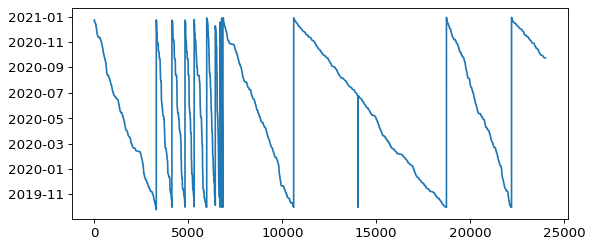

In [15]:
all_headlines_df['versionCreated'].plot()

In [27]:
# Сохранить версию all_headlines_df
file_version = 1
folder_name = 'C:/DAN/t_systems/trade_project/backup_headlines/'
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
# C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
file_path = folder_name + file_name
all_headlines_df.to_csv(file_path, sep = '~', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-30_v5.csv


In [28]:
# Сохранить версию логгера
file_version = 1
folder_name = 'C:/DAN/t_systems/trade_project/logger/'
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
file_path = folder_name + file_name
quasi_logger.to_csv(file_path, sep = ';', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/logger/quasi_logger_2020-12-30_v4.csv


In [65]:
print('StoryId duplicated:', all_headlines_df['storyId'].duplicated().sum())
print('Rows in df duplicated:', all_headlines_df.duplicated().sum())
print()
print('    Number of NA:')
print(len(all_headlines_df) - all_headlines_df.notna().sum())

StoryId duplicated: 1897
Rows in df duplicated: 247

    Number of NA:
ric                 0
versionCreated      0
headline            0
storyId             0
sourceCode          0
story             153
dtype: int64
